#### Time Series Preparation & Feature Engineering

This notebook focuses on preparing the passenger demand time series
for forecasting by analyzing stationarity, variance, and seasonality.


In [1]:
# Import Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
df = pd.read_csv("../data/raw/Air_Traffic_Passenger_Statistics.csv")

# Rebuild monthly data cleanly

df["Passenger Count"] = (
    df["Passenger Count"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df["Passenger Count"] = pd.to_numeric(df["Passenger Count"], errors="coerce")
df = df.dropna(subset=["Passenger Count"])

monthly_demand = (
    df.groupby("Activity Period", as_index=False)["Passenger Count"]
      .sum()
)

monthly_demand["Activity Period"] = pd.to_datetime(
    monthly_demand["Activity Period"].astype(str),
    format="%Y%m"
)

monthly_demand = monthly_demand.sort_values("Activity Period")

In [3]:
# Set Time Index

ts = monthly_demand.copy()
ts = ts.set_index("Activity Period")
ts = ts.sort_index()

ts.head()

,Passenger Count
Activity Period,
1999-07-01,3976746
1999-08-01,3972694
1999-09-01,3341964
1999-10-01,3468846
1999-11-01,3145240


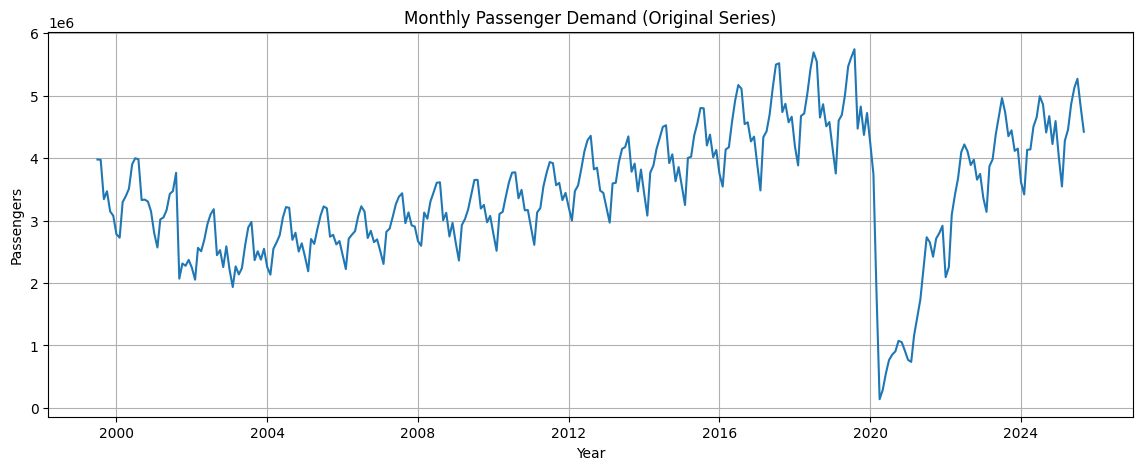

In [4]:
# Visual Stationarity Check

plt.figure(figsize=(14, 5))
plt.plot(ts["Passenger Count"])
plt.title("Monthly Passenger Demand (Original Series)")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

In [5]:
# ADF Test

adf_result = adfuller(ts["Passenger Count"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -3.1149375757271325
p-value: 0.02546730964347728


In [6]:
# KPSS Test

kpss_stat, p_value, _, _ = kpss(ts["Passenger Count"], regression="c")

print("KPSS p-value:", p_value)

KPSS p-value: 0.01106200574457434


Visual inspection and the KPSS test indicate that the raw passenger demand series is non-stationary due to trend, seasonality, and structural breaks. Although the ADF test suggested stationarity, it is not robust to seasonal patterns. Therefore, the series requires transformation before modeling.

In [7]:
# Log Transformation

ts["log_passengers"] = np.log(ts["Passenger Count"])

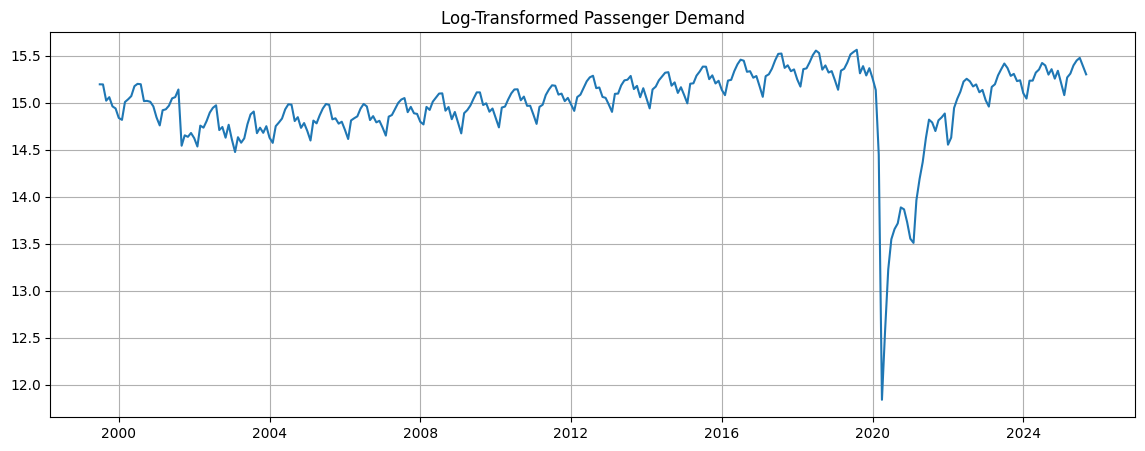

In [8]:
plt.figure(figsize=(14, 5))
plt.plot(ts["log_passengers"])
plt.title("Log-Transformed Passenger Demand")
plt.grid(True)
plt.show()

In [9]:
# First-Order Differencing

ts["log_diff_1"] = ts["log_passengers"].diff()

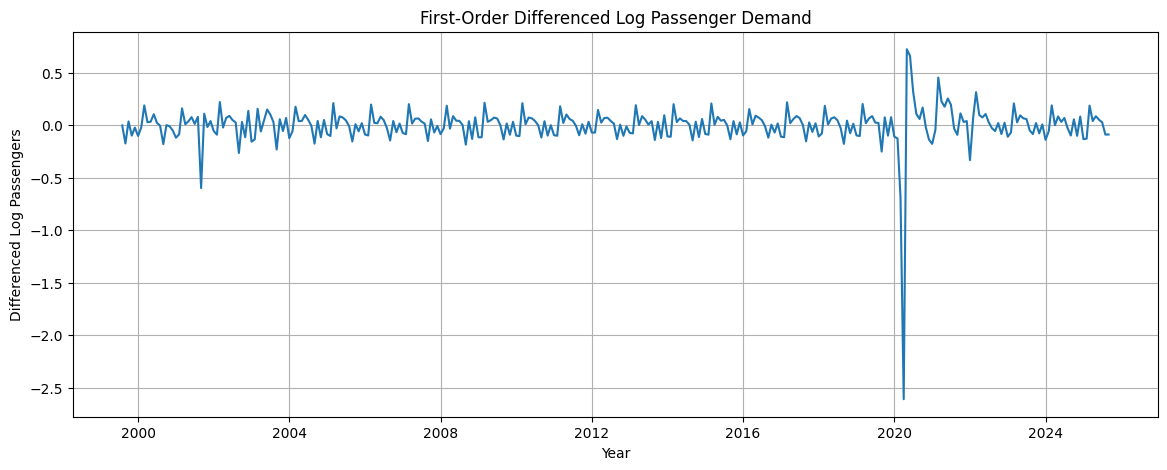

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(ts["log_diff_1"])
plt.title("First-Order Differenced Log Passenger Demand")
plt.xlabel("Year")
plt.ylabel("Differenced Log Passengers")
plt.grid(True)
plt.show()

In [11]:
# ADF Test After First Differencing

adf_diff = adfuller(ts["log_diff_1"].dropna())

print("ADF Statistic:", adf_diff[0])
print("p-value:", adf_diff[1])

ADF Statistic: -5.443213716197323
p-value: 2.746715112185962e-06


In [12]:
# Seasonal Differencing

ts["log_diff_seasonal"] = ts["log_passengers"].diff(12)

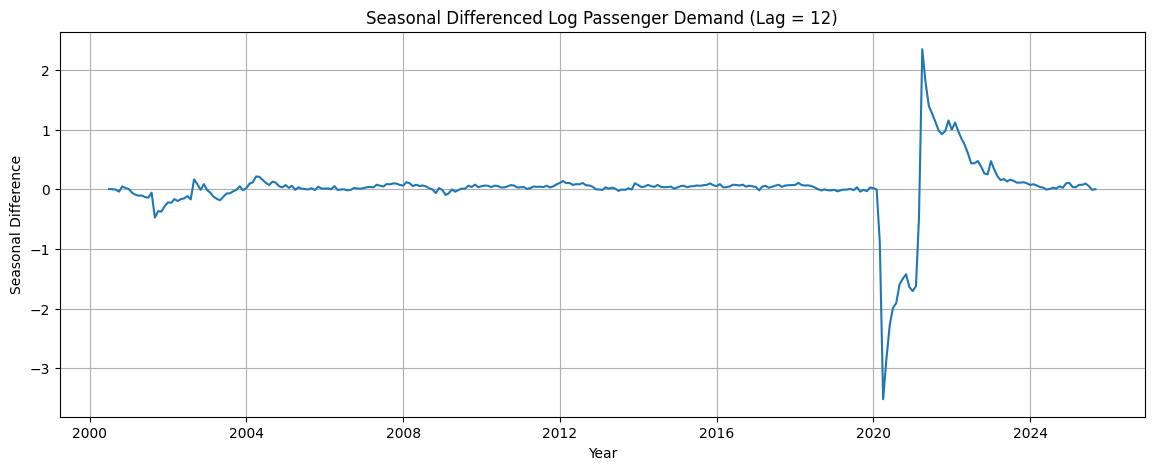

In [13]:
plt.figure(figsize=(14, 5))
plt.plot(ts["log_diff_seasonal"])
plt.title("Seasonal Differenced Log Passenger Demand (Lag = 12)")
plt.xlabel("Year")
plt.ylabel("Seasonal Difference")
plt.grid(True)
plt.show()

In [14]:
ts["log_diff_1_seasonal"] = ts["log_passengers"].diff().diff(12)

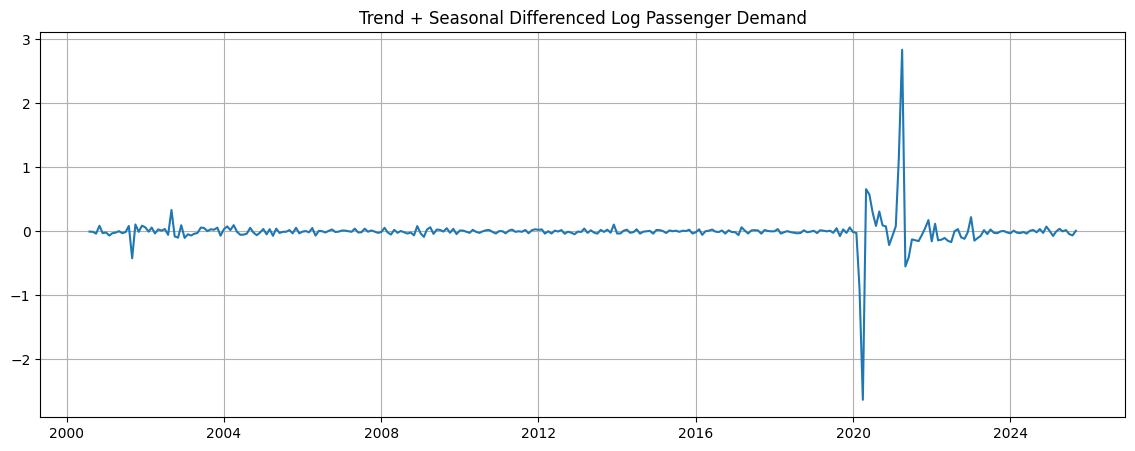

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(ts["log_diff_1_seasonal"])
plt.title("Trend + Seasonal Differenced Log Passenger Demand")
plt.grid(True)
plt.show()

In [16]:
adf_final = adfuller(ts["log_diff_1_seasonal"].dropna())
print("ADF p-value:", adf_final[1])

ADF p-value: 9.759202673821426e-10


Seasonal differencing with a 12-month lag successfully removed the yearly seasonal component. Combined trend and seasonal differencing produced a stationary series, confirmed by an ADF p-value near zero. This transformed series is suitable for SARIMA and other time-series forecasting models.

Although classical time-series models require strict stationarity,
machine learning models (LightGBM, XGBoost) were later used as they
can handle non-stationary patterns using lag-based features.